# Exploration_05

목적: train 학습파일을 활용하여 price 예측해보기.

- 여러가지 모델 및 하이퍼 파라미터를 조정하여 최적의 값을 찾아볼 예정.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
tried = 0 #마지막에, 시도한 횟수를 알아보기 위함
import sys

# 데이터 전처리

In [8]:
data_dir = '/content/drive/MyDrive/LMS/Exploration/Ex.5/data'

train_data_path = data_dir + '/train.csv'
test_data_path = data_dir + '/test.csv' # 제출할 때 test로 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


#### 학습데이터에서 Label값인 price는 y로 저장 후 삭제

In [9]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 데이터 전처리를 위해 학습데이터와 테스트 데이터 합치기


In [10]:
# 학습할 때는 다시 분리해야 하기 때문에, training data의 개수를 저장한다.
train_len = len(train)
train = pd.concat((train, test), axis = 0)

print(len(train))

21503


### 결측치 찾기

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


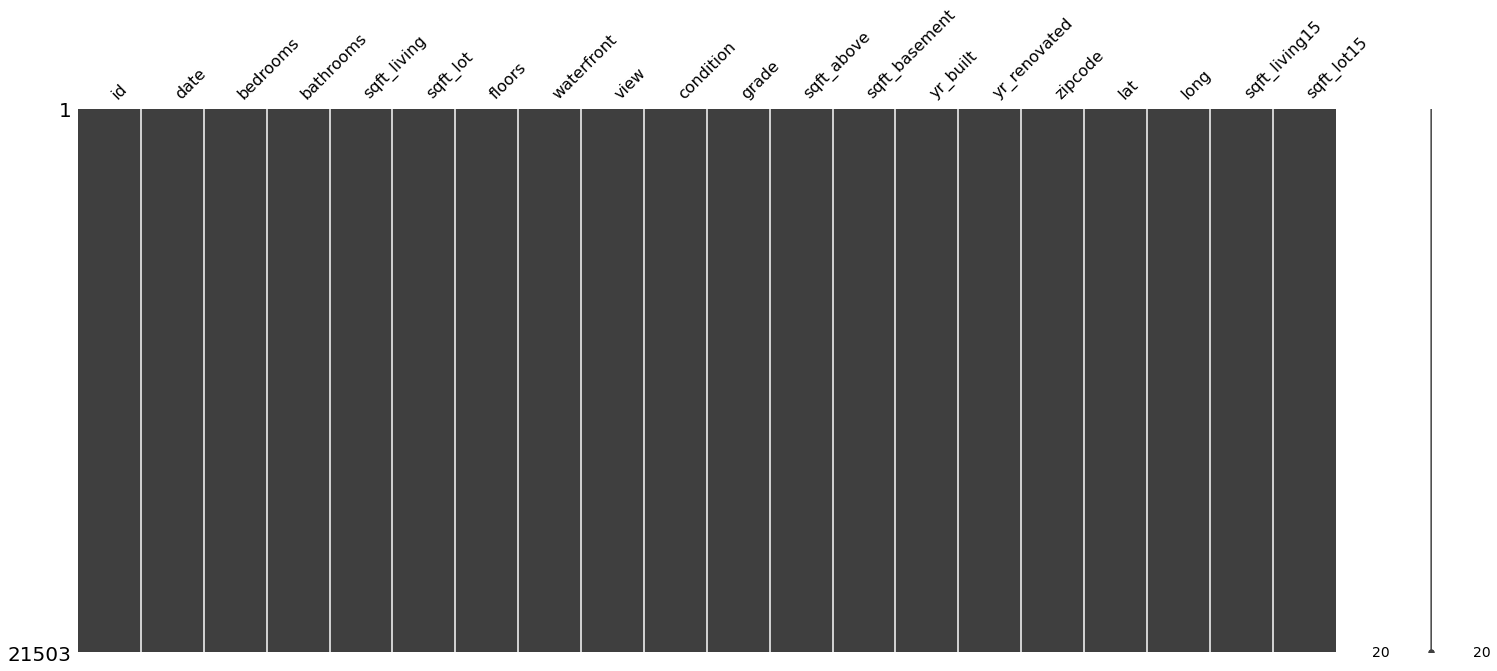

In [11]:
import missingno as msno

msno.matrix(train)

for c in train.columns:
  print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

#### 필요없는 칼럼 제거하기

In [12]:
del train['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 치우친 그래프 확인

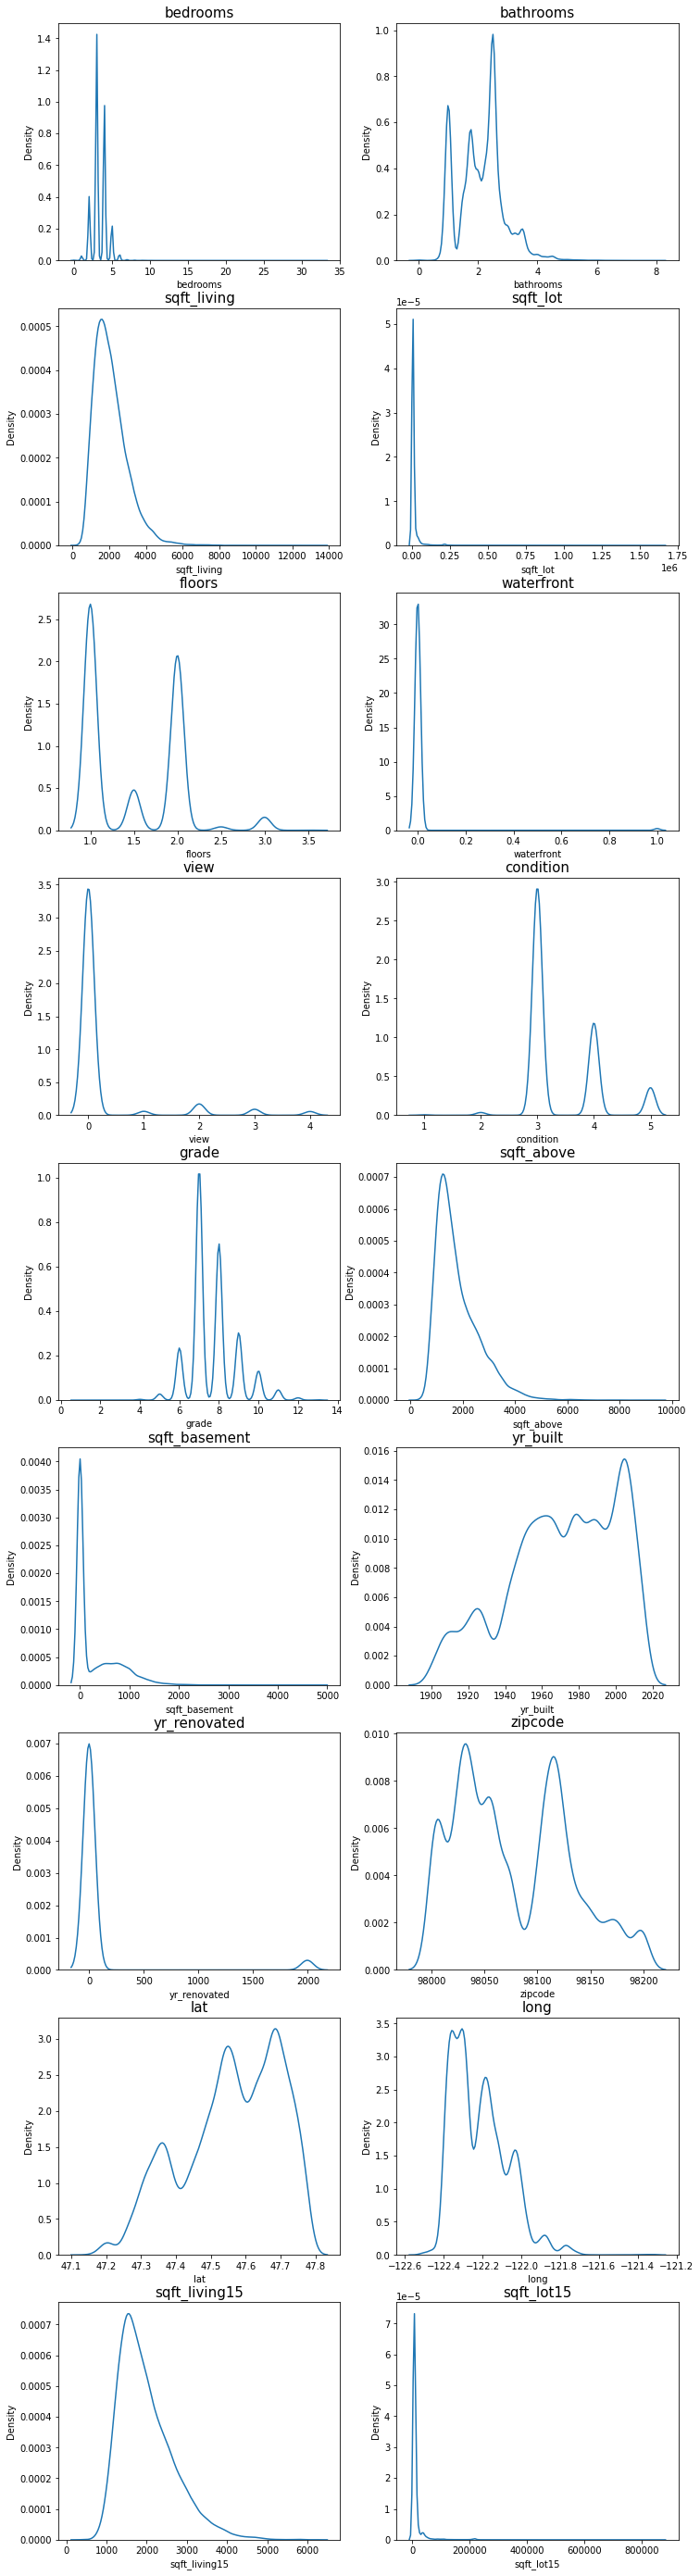

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(9,2, figsize = (12,50)) #figsize를 통해 그래프 사이즈 변경 가능.

# id 변수(count == 0 인경우)를 제외하고, 분포를 확인한다.

count = 1
columns = train.columns
for row in range(9):
  for col in range(2):
    sns.kdeplot(data = train[columns[count]], ax = ax[row][col])
    ax[row][col].set_title(columns[count], fontsize = 15)
    count += 1
    if count == 19:
      break

#### np.log1p()로 로그변환하여 정규화

In [14]:
skew_columns = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
  train[c] = np.log1p(train[c].values)

#### 변화 분포 확인

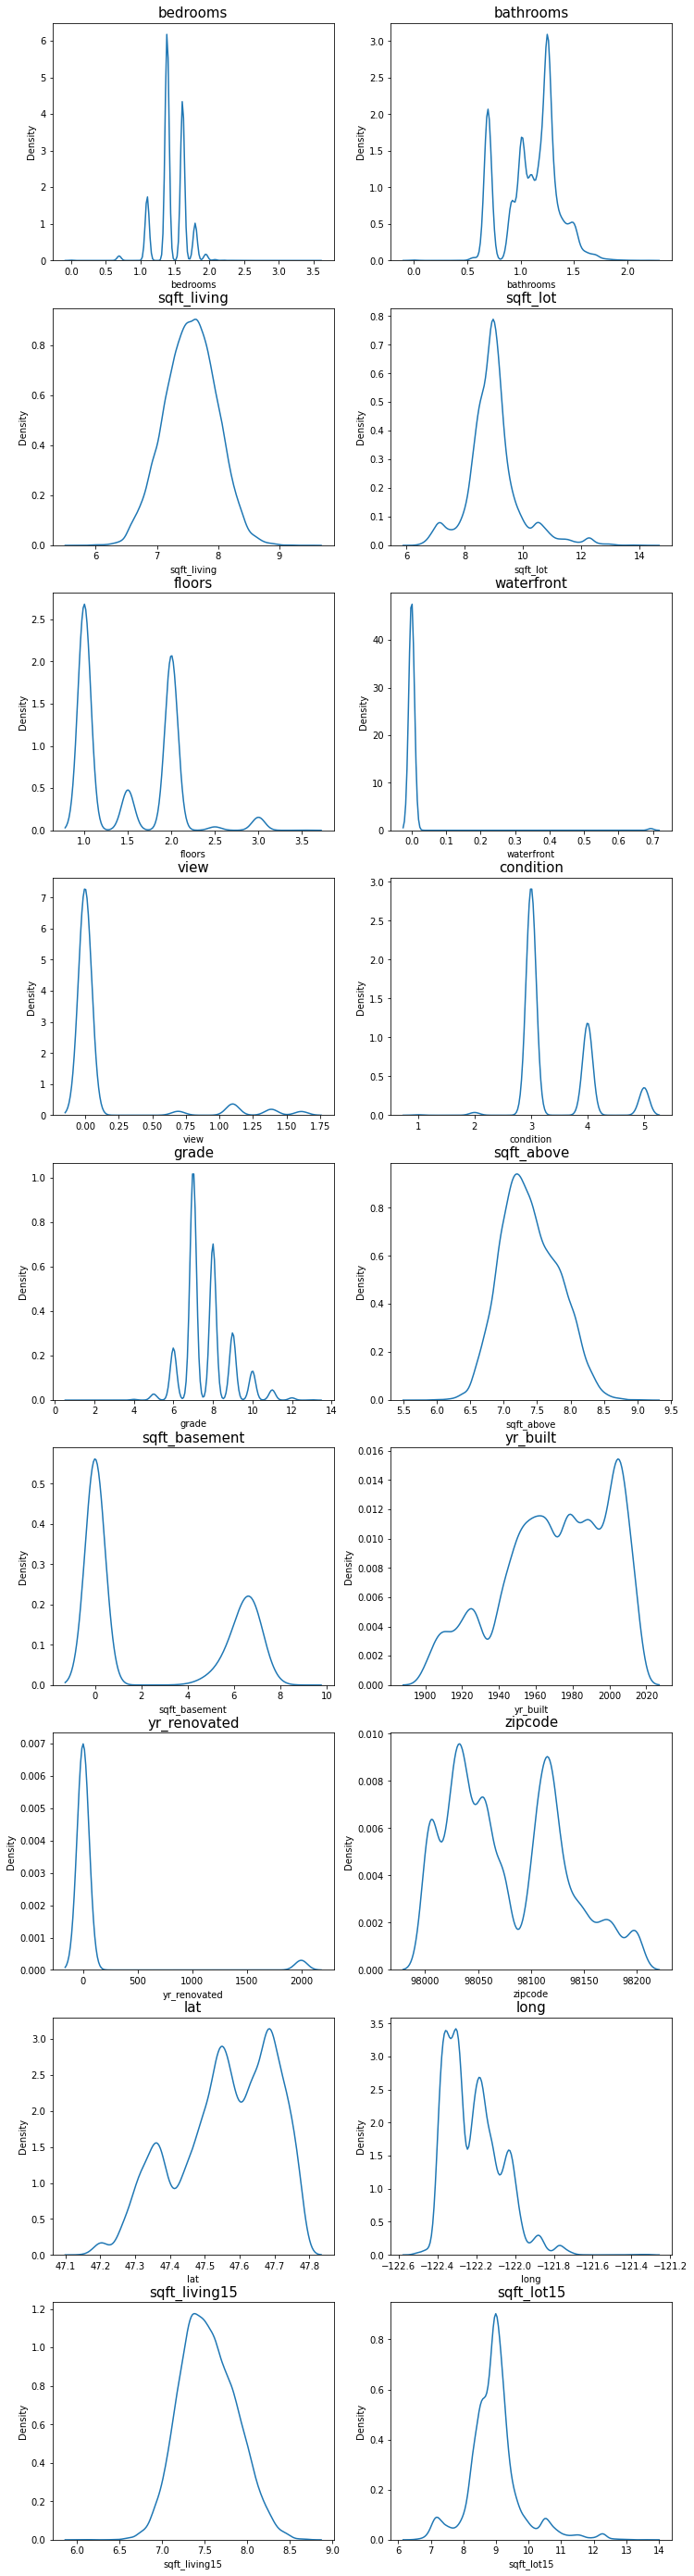

In [15]:
fig, ax = plt.subplots(9,2, figsize = (12,50))

count = 1
columns = train.columns
for row in range(9):
  for col in range(2):
    sns.kdeplot(data = train[columns[count]], ax = ax[row][col])
    ax[row][col].set_title(columns[count], fontsize = 15)
    count += 1
    if count == 19:
      break

#### 타겟 집의 가격인 train[price]의 분포를 확인하고 정규화 하기

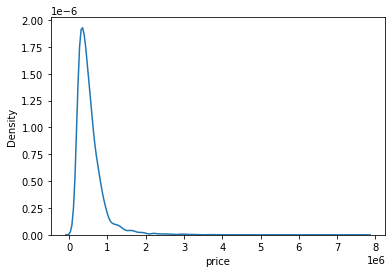

In [16]:
sns.kdeplot(y)
plt.show()

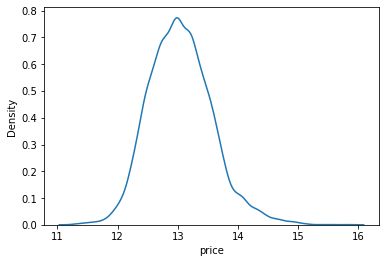

In [17]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

# train과 test로 다시 나누기

In [18]:
test = train.iloc[train_len:, :]
train = train.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  float64
 7   view           15035 non-null  float64
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  float64
 18  sqft_l

In [20]:
from sklearn.model_selection import train_test_split # 훈련/검증 데이터셋으로 나누기 위한 train_test_split함수 불러오기
from sklearn.metrics import mean_squared_error # RMSE점수를 계산하기 위한 mean_squared_error 불러오기

#### RMSE함수를 만들건데, 위에서 정규화를 위해 y를 log로 변환해 줬으니, 다시 exp^-1를 붙여 반환

In [21]:
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print("RMSE function created.")

RMSE function created.


#### 앞으로 시도해 볼 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델 불러오기

In [261]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## 아래 코드 부터는, 하이퍼 파라미터를 input 받아서, 편하게 비교하기 위해 다소 난잡한 코드들 삽입. 

#### 시드 고정

In [345]:
moodels = []
def random_state(randn):
  gboost = GradientBoostingRegressor(random_state = randn)
  xgboost = XGBRegressor(random_state = randn)
  lightgbm = LGBMRegressor(random_state = randn)
  rdforest = RandomForestRegressor(random_state = randn)
  global moodels
  global getnum
  while True:
    getnum = int(input("[1]:Use all model\n[2]:remove LGRMRegressor\n [3]:remove LGRM+RandomForest\n[4]:remove LGRM+RandomForest+GBR\n"))
    if getnum == 1:
      moodels = [gboost, xgboost,lightgbm, rdforest]
      return False
    elif getnum == 2:
      moodels = [gboost, xgboost, rdforest]
      return False
    elif getnum == 3:
      moodels = [gboost, xgboost]
      return False
    elif getnum == 4:
      moodels = [xgboost]
      return False
    else:
      print("out of number")
      continue

  print("Seed number \"",randn, "\"created !")

In [346]:
def random_state2(btgoodvalue, nlgoodvalue, depthgoodvalue, lrgoodvalue, estigoodvalue, randn):
  gboost = GradientBoostingRegressor(max_depth = depthgoodvalue, learning_rate = lrgoodvalue, n_estimators = estigoodvalue, random_state = randn)
  xgboost = XGBRegressor(max_depth = depthgoodvalue, learning_rate = lrgoodvalue, n_estimators = estigoodvalue, random_state = randn)
  lightgbm = LGBMRegressor(boosting_type = btgoodvalue, num_leaves = nlgoodvalue, max_depth = depthgoodvalue, learning_rate = lrgoodvalue, n_estimators = estigoodvalue, random_state = randn)
  rdforest = RandomForestRegressor(max_depth = depthgoodvalue, n_estimators = estigoodvalue, random_state = randn)


  global moodels
  if getnum == 1:
    moodels = [gboost, xgboost,lightgbm, rdforest]
  elif getnum == 2:
    moodels = [gboost, xgboost, rdforest]
  elif getnum == 3:
    moodels = [gboost, xgboost]
  else:
    moodels = [xgboost]
              
  print("\nSeed number \"",randn, "\"created !")
  print("max_depth: ",depthgoodvalue)
  print("n_estimators: ", estigoodvalue)
  print("learning_rate: ", lrgoodvalue)
  print("num_leaves: ", nlgoodvalue)
  print("boosting_type: ", btgoodvalue)

  global model
  for i in range(len(moodels)):
   if getsmallmodel in str(moodels[i]):
     model = moodels[i]
   else:
      continue
  print("Model: ",model)


In [364]:
findsmall = {}
testsize = 0.2
def get_score(modelss, train, y):
  global findsmall
  global testsize
  df = {}
  findsmall = {}

  for modell in modelss:
    model_name = modell.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state = int(randn), test_size = testsize)
    modell.fit(X_train, y_train)

    y_pred = modell.predict(X_test)

    df[model_name] = rmse(y_test, y_pred)
    score_df = pd.DataFrame(df, index = ['RMSE']).T.sort_values('RMSE', ascending = False)

    findsmall[model_name] = rmse(y_test, y_pred)
  
  global model
  getsmallmodel = min(findsmall, key = findsmall.get)
  for i in range(len(modelss)):
    if getsmallmodel in str(modelss[i]):
     model = modelss[i]
    else:
      continue

  return score_df


#### GridSearchCV 클래스를 이용하여 탐색

In [348]:
from sklearn.model_selection import GridSearchCV
param_grid = {}
def param_gridf(nlnum, n_estimators_start,n_estimators_end,lr_start, lr_end, max_depth_start,max_depth_end, btype):
  global param_grid
  
  if getsmallmodel == "GradientBoostingRegressor" or getsmallmodel == "XGBRegressor":
    param_grid = {'n_estimators': [int(n_estimators_start), int(n_estimators_end)], 
                'max_depth': [int(max_depth_start),int(max_depth_end)],
                'learning_rate': [float(lr_start), float(lr_end)]}
    
  elif getsmallmodel == "RandomForestRegressor":
    param_grid = {'n_estimators': [int(n_estimators_start), int(n_estimators_end)], 
                'max_depth': [int(max_depth_start),int(max_depth_end)]}
  else:
    param_grid = {'n_estimators': [int(n_estimators_start), int(n_estimators_end)], 
                'max_depth': [int(max_depth_start),int(max_depth_end)],
                'num_leaves': [int(nlnum)],
                'learning_rate': [float(lr_start), float(lr_end)],
                'boosting_type': [str(btype)]}

### GridSearchCV를 이용하여 최적의 하이퍼파라미터 조합 찾기

In [349]:
verbose = 2
n_jobs = 5
rrsult = pd.DataFrame()
depthgoodvalue = 0
estigoodvalue = 0
nlgoodvalue = 0
lrgoodvalue = 0.0
btgoodvalue = None

def my_GridSearch(model, train, y, param_grid, verbose = verbose, n_jobs = n_jobs):
  # GridSearchSV 모델로 초기화
  grid_model = GridSearchCV(model, param_grid = param_grid, scoring = 'neg_mean_squared_error', \
                            cv = 5, verbose = verbose, n_jobs = n_jobs)
  
  # 모델 fitting
  grid_model.fit(train, y)

  # 결과값 저장
  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']

  # 데이터 프레임 생성
  results = pd.DataFrame(params)
  results['score'] = score

  # RMSLE 값 계산 후 정렬
  results['RMSLE'] = np.sqrt(-1 * results['score'])
  results = results.sort_values('RMSLE')

  global rrsult
  rrsult = results



  soort = rrsult["RMSLE"]
  goodnum = 0

  for i in range(len(soort)):
    if soort[i] == min(soort):
      goodnum = i
    else:
      continue
  global depthgoodvalue
  global estigoodvalue
  global lrgoodvalue
  global nlgoodvalue
  global btgoodvalue
  if getsmallmodel == "GradientBoostingRegressor" or getsmallmodel == "XGBRegressor":
    depthgoodvalue = rrsult["max_depth"][goodnum]
    estigoodvalue = rrsult["n_estimators"][goodnum]
    lrgoodvalue = rrsult["learning_rate"][goodnum]
  elif getsmallmodel == "RandomForestRegressor":
    depthgoodvalue = rrsult["max_depth"][goodnum]
    estigoodvalue = rrsult["n_estimators"][goodnum]
  else:
    depthgoodvalue = rrsult["max_depth"][goodnum]
    estigoodvalue = rrsult["n_estimators"][goodnum]
    lrgoodvalue = rrsult["learning_rate"][goodnum]
    nlgoodvalue = rrsult["num_leaves"][goodnum]
    btgoodvalue = rrsult["boosting_type"][goodnum]

  return results

## 기록 저장용

#### 사용하려 했으나, 어떠한 오류 때문인지, sys.stdout.close()시, 프로그램이 계속 멈추어서 기록하지 못하고, 수동 저장만 하기로 했다.

In [29]:
# def saveresults(tried, randn, n_estimators_start, n_estimators_end, max_depth_start, max_depth_end, verbose, n_jobs, getsmallmodel, depthgoodvalue, estigoodvalue):
#   sys.stdout = open('Save_Results.txt', 'w')
#   print("Try: ", tried,
#         "\nradom state: [",randn, "]",
#         "input n_estimators: [",n_estimators_start,":",n_estimators_end, "]",
#         "input max_depth: [", max_depth_start,":", max_depth_end, "]",
#         "verbose: [", verbose, "]",
#         "n_jobs: [", n_jobs, "]",
#         "\nmodel chosen:[", getsmallmodel,"]",
#         "\tmax_depth chosen: [", depthgoodvalue, "]",
#         "n_estimators chosen: [", estigoodvalue, "]",
#         "\n\nlowest RMSLE: ", min(rrsult["RMSLE"]),
#         "\n","="*30)
#   sys.stdout.close()

## 제출 파일 자동 저장 함수

In [324]:
def save_submission(model, train, y, test, model_name, rmsle = None):
  #1. 모델을 'train', 'y'로 학습
  model.fit(train, y)

  #2. 'test'에 대해 예측
  prediction = model.predict(test)
  prediction = np.expm1(prediction)
  data_dir = '/content/drive/MyDrive/LMS/Exploration/Ex.5/data'
  submission_path = data_dir + '/sample_submission.csv'
  submission = pd.read_csv(submission_path)

  #3. 예측값을 'np.expm1'으로 변경하고, 'submission_model_name_RMSLE_100000.csv' 형태의 'csv'파일을 저장합니다.
  submission['price'] = prediction
  submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
  submission.to_csv(submission_csv_path, index = False)
  print('{} saved!'.format(submission_csv_path))

# input으로 하이퍼 파라미터값을 받아, 편하게 비교.

In [389]:
randn = int(input("Put the random state number: "))  # 랜덤시드
random_state(randn)
testsize = float(input("Test size: "))
get_score(moodels, train, y) # 성능좋은 모델 찾기
getsmallmodel = min(findsmall, key = findsmall.get)
print("model \"",getsmallmodel,"\"chosen.")

# param_grid set
print("\n==param_grid set ==\n")
if getsmallmodel == "LGBMRegressor" or getsmallmodel =="GradientBoostingRegressor" or getsmallmodel =="XGBRegressor":
  lr_start = input("learning_rate: 한스텝에 이동하는 양(보통 0.05~0.1사이)\nlearning_rate starts: ")
  lr_end = input("learning_rate ends: ")
else: pass
max_depth_start = input("max_deapth: 의사결정나무 깊이(default: 1)\nmax_depth starts: ")
max_depth_end = input("max_depth ends: ")
n_estimators_start = input("사용하는 개별 모델 개수(보통 50~100 이상 정수)\nn_estimators starts: ")
n_estimators_end = input("n_estimators ends: ")
if getsmallmodel == "LGBMRegressor":
  nlnum = input("num_leaves: (2의 거듭제곱)-1 값.(default: 31)\nnum_leaves: ")
  btype = input("lightGBM: rf(Random Forest) / gbdt(Gradient Boosted Decision Trees) / dart(드랍아웃 Regression Trees) / goss (Gradient-based One Side Sampleing)\ndefault:gbdt\nboosting_type: ")
else: pass

# if getsmallmodel == "GradientBoostingRegressor" or getsmallmodel =="XGBRegressor":
#   param_gridf(nlnum, n_estimators_start,n_estimators_end,lr_start, lr_end, max_depth_start, max_depth_end)
# elif getsmallmodel == "RandomForestRegressor":
#   param_gridf(n_estimators_start,n_estimators_end, max_depth_start,max_depth_end)
# else:
param_gridf(nlnum, n_estimators_start,n_estimators_end,lr_start, lr_end, max_depth_start,max_depth_end, btype)

# GridSearch
verbose = int(input("\nverbose: 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메시지의 양(숫자가 클수록 더 많은 메시지를 출력 (초깃값: 1)\nverbose: "))
n_jobs =  int(input("n_jobs: 그리드 탐색을 진행하면서 사용할 CPU 개수 (초깃값: 5)\nn_jobs: "))
print("\n===GridSerch에 사용되는 하이퍼 파라미터===")
print("Model: ",getsmallmodel)
print("Param_grid: ",param_grid)
print("verbose: ",verbose)
print("n_jobs: ",n_jobs)

# 최적의 하이퍼 파라미터 값 찾기
my_GridSearch(model, train, y, param_grid, verbose = verbose, n_jobs = n_jobs)

# 찾은 값 적용
# if getsmallmodel == "GradientBoostingRegressor" or getsmallmodel =="XGBRegressor":
#   random_state2(nlgoodvalue, depthgoodvalue, lrgoodvalue, estigoodvalue, randn)
# elif getsmallmodel == "RandomForestRegressor":
#   random_state2(depthgoodvalue, estigoodvalue, randn)
# else: 
random_state2(btgoodvalue, nlgoodvalue, depthgoodvalue, lrgoodvalue, estigoodvalue, randn)

print("\nat RMSLE ", min(rrsult['RMSLE']))


model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)

submission_path = data_dir + '/sample_submission.csv'
submission = pd.read_csv(submission_path)

submission['price'] = prediction
submission.head()



Put the random state number: 2020
[1]:Use all model
[2]:remove LGRMRegressor
 [3]:remove LGRM+RandomForest
[4]:remove LGRM+RandomForest+GBR
1
Test size: 0.2
[13:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model " LGBMRegressor "chosen.

==param_grid set ==

learning_rate: 한스텝에 이동하는 양(보통 0.05~0.1사이)
learning_rate starts: 0.05
learning_rate ends: 0.1
max_deapth: 의사결정나무 깊이(default: 1)
max_depth starts: 10
max_depth ends: 30
사용하는 개별 모델 개수(보통 50~100 이상 정수)
n_estimators starts: 300
n_estimators ends: 500
num_leaves: (2의 거듭제곱)-1 값.(default: 31)
num_leaves: 255
lightGBM: rf(Random Forest) / gbdt(Gradient Boosted Decision Trees) / dart(드랍아웃 Regression Trees) / goss (Gradient-based One Side Sampleing)
default:gbdt
boosting_type: gbdt

verbose: 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메시지의 양(숫자가 클수록 더 많은 메시지를 출력 (초깃값: 1)
verbose: 2
n_jobs: 그리드 탐색을 진행하면서 사용할 CPU 개수 (초깃값: 5)
n_jobs: 5

===GridSerch에 사용되는 하이퍼 파라미터===
Model:  LGBMReg

,id,price
0,15035,5.078148e+05
1,15036,5.138241e+05
2,15037,1.401114e+06
3,15038,2.763753e+05
4,15039,3.308732e+05


In [391]:
results_RMSLE = str(min(rrsult['RMSLE']))[:6]
save_submission(model, train, y, test, 'lgbm', rmsle = results_RMSLE)

/content/drive/MyDrive/LMS/Exploration/Ex.5/data/submission_lgbm_RMSLE_0.1654.csv saved!


In [390]:
tried += 1

print("Try: ", tried,
      "\nradom state: [",randn, "]",
      "input n_estimators: [",n_estimators_start,":",n_estimators_end, "]",
      "input max_depth: [", max_depth_start,":", max_depth_end, "]",
      "verbose: [", verbose, "]",
      "n_jobs: [", n_jobs, "]",
      "learning_rate: [",lr_start,":", lr_end, "]",
      "num_leaves: [",nlnum, "]",
      "boosting_type: [", btype, "]",
      "\nmodel chosen:[", getsmallmodel,"]",
      "\tmax_depth chosen: [", depthgoodvalue, "]",
      "n_estimators chosen: [", estigoodvalue, "]",
      "learning_rate: [", lrgoodvalue, "]",
      "num_leaves: [", nlgoodvalue, "]",
      "\n\nlowest RMSLE: ", min(rrsult["RMSLE"]),
      "\n","="*30)

Try:  46 
radom state: [ 2020 ] input n_estimators: [ 300 : 500 ] input max_depth: [ 10 : 30 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 255 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 300 ] learning_rate: [ 0.05 ] num_leaves: [ 255 ] 

lowest RMSLE:  0.16545031130182447 


##시도해본 하이퍼 파라미터 결과

Try:  1 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 1 ] n_jobs: [ 5 ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] 

lowest RMSLE:  0.1643909379702034 
 ==============================

Try:  2 
radom state: [ 1000 ] input n_estimators: [ 0 : 1000 ] input max_depth: [ 0 : 100 ] verbose: [ 5 ] n_jobs: [ 5 ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 100 ] n_estimators chosen: [ 1000 ] 

lowest RMSLE:  0.16360428354643594 
 ==============================

Try:  3 
radom state: [ 500 ] input n_estimators: [ 1001 : 2000 ] input max_depth: [ 101 : 500 ] verbose: [ 1 ] n_jobs: [ 5 ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 500 ] n_estimators chosen: [ 1001 ] 

lowest RMSLE:  0.16360322444646047 
 ==============================

Try:  4 
radom state: [ 1500 ] input n_estimators: [ 0 : 3000 ] input max_depth: [ 0 : 1000 ] verbose: [ 1 ] n_jobs: [ 5 ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 1000 ] n_estimators chosen: [ 3000 ] 

lowest RMSLE:  0.16595952300358344 
 ==============================

Try:  5
radom state: [ 500 ] input n_estimators: [ 200 : 250 ] input max_depth: [ 500 : 700 ] verbose: [ 1 ] n_jobs: [ 5 ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 700 ] n_estimators chosen: [ 250 ] 

lowest RMSLE:  0.1616363978680456 
 ==============================

Try:  6
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 1 ] n_jobs: [ 5 ] 
model chosen:[ RandomForestRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] 

lowest RMSLE:  0.18762125772505892 
 ==============================

Try:  7
radom state: [ 2020 ] input n_estimators: [ 100 : 200 ] input max_depth: [ 1 : 11 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 63 ] boosting_type: [ dart ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 11 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 63 ] 

lowest RMSLE:  0.7993024368056038 
 ==============================

Try:  8 
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 1 : 11 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.2 ] num_leaves: [ 63 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 11 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 63 ] 

lowest RMSLE:  0.3172211171648426 
 ==============================

Try:  9 
radom state: [ 2020 ] input n_estimators: [ 1 : 300 ] input max_depth: [ 1 : 50 ] verbose: [ 1 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.2 ] num_leaves: [ 31 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 50 ] n_estimators chosen: [ 1 ] learning_rate: [ 0.2 ] num_leaves: [ 31 ] 

lowest RMSLE:  0.4483910329145707 
 ==============================

Try:  10 
radom state: [ 2020 ] input n_estimators: [ 50 : 300 ] input max_depth: [ 1 : 20 ] verbose: [ 1 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 20 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.17628614607437346 
 ==============================

Try:  11 
radom state: [ 2020 ] input n_estimators: [ 100 : 500 ] input max_depth: [ 1 : 30 ] verbose: [ 1 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 1023 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 30 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 1023 ] 

lowest RMSLE:  17.23503787131171 
 ==============================

Try:  12 
radom state: [ 2020 ] input n_estimators: [ 50 : 300 ] input max_depth: [ 1 : 300 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 1024 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 300 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 1024 ] 

lowest RMSLE:  0.17927617357226105 
 ==============================

Try:  20 
radom state: [ 2020 ] input n_estimators: [ 50 : 50 ] input max_depth: [ 10 : 10 ] verbose: [ 2 ] n_jobs: [ 1 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.18483377488470284 
 ==============================

Try:  21 
radom state: [ 2020 ] input n_estimators: [ 50 : 50 ] input max_depth: [ 10 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.18483377488470284 
 ==============================

Try:  22 
radom state: [ 2020 ] input n_estimators: [ 50 : 50 ] input max_depth: [ 1 : 1 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 1 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.8991884927840281 
 ==============================

Try:  23 
radom state: [ 2020 ] input n_estimators: [ 50 : 50 ] input max_depth: [ 20 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 20 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.17628614607437346 
 ==============================

Try:  24 
radom state: [ 2020 ] input n_estimators: [ 200 : 200 ] input max_depth: [ 10 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 20 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.18034352730774758 
 ==============================

Try:  25
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 10 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.001 : 0.1 ] num_leaves: [ 255 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.1 ] num_leaves: [ 255 ] 

lowest RMSLE:  0.1669630182772662 
 ==============================

Try:  26 
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 10 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.01 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.1 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.16530472202567387 
 ==============================

Try:  27 
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 10 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.01 : 0.1 ] num_leaves: [ 15 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.1 ] num_leaves: [ 15 ] 

lowest RMSLE:  0.1638372336253207 
 ==============================

Try:  28 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 31 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 31 ] 

lowest RMSLE:  0.1643909379702034 
 ==============================

Try:  29 
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 1 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.01 : 0.1 ] num_leaves: [ 7 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 20 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.1 ] num_leaves: [ 7 ] 

lowest RMSLE:  0.17077377105562852 
 ==============================

Try:  30 
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 10 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.01 : 0.1 ] num_leaves: [ 7 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 20 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.1 ] num_leaves: [ 7 ] 

lowest RMSLE:  0.17077377105562852 
 ==============================

Try:  31 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 15 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 15 ] 

lowest RMSLE:  0.1684527514070248 
 ==============================

Try:  32 
radom state: [ 2020 ] input n_estimators: [ 100 : 300 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.01 : 0.2 ] num_leaves: [ 15 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 300 ] learning_rate: [ 0.2 ] num_leaves: [ 15 ] 

lowest RMSLE:  0.16441400384169447 
 ==============================

Try:  33 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 15 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 15 ] 

lowest RMSLE:  0.1684527514070248 
 ==============================

Try:  34 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 31 ] boosting_type: [ gbdt ] 
model chosen:[ GradientBoostingRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 0 ] 

lowest RMSLE:  0.17160440504927346 
 ==============================

Try:  35 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 31 ] boosting_type: [ gbdt ] 
model chosen:[ XGBRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 0 ] 

lowest RMSLE:  0.16448429542851078 
 ==============================

Try:  36 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 31 ] boosting_type: [ gbdt ] 
model chosen:[ XGBRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 0 ] 

lowest RMSLE:  0.16448429542851078 
 ==============================

Try:  37 
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 1 : 10 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.16434085424050812 
 ==============================

Try:  38 
radom state: [ 2020 ] input n_estimators: [ 50 : 200 ] input max_depth: [ 10 : 20 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.001 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ XGBRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.1 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.16390298160065553 
 ==============================

Try:  39 
radom state: [ 2020 ] input n_estimators: [ 100 : 200 ] input max_depth: [ 10 : 15 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.005 : 0.05 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 15 ] n_estimators chosen: [ 200 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.16393147316742235 
 ==============================

Try:  40 
radom state: [ 2020 ] input n_estimators: [ 100 : 150 ] input max_depth: [ 10 : 15 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.001 : 0.005 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ XGBRegressor ] 	max_depth chosen: [ 15 ] n_estimators chosen: [ 150 ] learning_rate: [ 0.005 ] num_leaves: [ 127 ] 

lowest RMSLE:  5.928774926792359 
 ==============================

Try:  41 
radom state: [ 2020 ] input n_estimators: [ 100 : 150 ] input max_depth: [ 10 : 15 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ dart ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 150 ] learning_rate: [ 0.1 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.5697478588097155 
 ==============================

Try:  42 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ -1 : -1 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ goss ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ -1 ] n_estimators chosen: [ 50 ] learning_rate: [ 0.05 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.1761775921792765 
 ==============================

Try:  43 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ -1 : -1 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ -1 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.16582629562611642 
 ==============================

Try:  44 
radom state: [ 2020 ] input n_estimators: [ 50 : 100 ] input max_depth: [ 10 : 15 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ GradientBoostingRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 100 ] learning_rate: [ 0.1 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.17160440504927346 
 ==============================

Try:  45 
radom state: [ 2020 ] input n_estimators: [ 100 : 150 ] input max_depth: [ 10 : 15 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 127 ] boosting_type: [ gbdt ] 
model chosen:[ RandomForestRegressor ] 	max_depth chosen: [ 15 ] n_estimators chosen: [ 150 ] learning_rate: [ 0.1 ] num_leaves: [ 127 ] 

lowest RMSLE:  0.17882107490579882 
 ==============================

Try:  46 
radom state: [ 2020 ] input n_estimators: [ 300 : 500 ] input max_depth: [ 10 : 30 ] verbose: [ 2 ] n_jobs: [ 5 ] learning_rate: [ 0.05 : 0.1 ] num_leaves: [ 255 ] boosting_type: [ gbdt ] 
model chosen:[ LGBMRegressor ] 	max_depth chosen: [ 10 ] n_estimators chosen: [ 300 ] learning_rate: [ 0.05 ] num_leaves: [ 255 ] 

lowest RMSLE:  0.16545031130182447 
 ==============================

# 회고

##이번 프로젝트를 하며 진행한 것
###1. 데이터 전처리
####먼저, 데이터의 구조에 대해 이해하기 위해 하나하나 코드를 직접 따라 써 보며 시작하였습니다. 그렇게 어느정도 구조파악이 되어서, 기존에서 했던 전처리에서 제가 더 만질 수 있는 전처리가 어떤것이 있을까 생각해보았습니다. 우선 결측치가 없다는 것은 확인하였고, 노드에서는 하지 않았던, column들의 정규화를 좀 더 진행하였습니다. 그 과정에서 DataFrame을 다루는 법에 대해 조금 이해하였습니다. 제가 해낸 전처리는 정규화 뿐이었는데, 조원께서 말씀해 주셔서 나중에 안 사실은, 데이터 자체의 값들을 이용하여 없는 정보를 만들어 내는 방법도 있다고 들었는데, 제출 마감시간이 얼마 남지 않아 시도해보지 못한것이 아쉬웠습니다.
###2. 코드분석
####하이퍼파라미터를 바꾸기 이전에, 각 모델들이 어떤 구조로 이루어 져 있고, 파라미터 값을 바꾼다면 어떤일들이 있을까 고민해 보았습니다. 노드에서 주신 링크를 꼼꼼히 읽어보았고, 바꿀 수 있는 파라미터를 시도해 보았습니다. 대부분 Default값에서 벗어나면 오히려 안좋은 결과를 초래하기에, 노드에서 말한, 가장 중요한 값들 위주로 바꿔 주었습니다.
###3. 파라미터 변환값 input기 생성
####아무래도, 코드에서 하나하나 하이퍼 파라미터를 바꾸려다보니, 다소 피로도가 있었으며, 모델을 한번 시도할 때 마다 적지않은 시간이 소모되고, 또한 다양한 하이퍼파라미터 값을 시도해 보고싶었기에, 이를 편안하게 input을 받아서 넣어주면 좀 더 간편하겠다! 라는 생각이 들어, 코드를 하나하나 다시 살펴가며 input 시스템을 만들었습니다. 그 덕분에 훨씬 수월하고 다양한 비교를 할 수 있었습니다.
###4. 값 히스토리 저장
####다양한 하이퍼파라미터에 대한 시도가 있었는데, 그 값의 변화를 알아가고 싶었기에, 그 값을 하나하나 정리하기로 하였습니다. 처음엔 f.open을 이용하여 자동으로 기록하고싶었지만, 코랩이 자꾸만 멈추는 바람에, 이러다간 지금까지 만들어 놓은것이 모두 수포로 돌아갈 수도 있겠구나 라는 생각이 들어 포기하였습니다. 하지만, 그냥 print를 이용하여 값을 복사하여 따로 메모장에 기록하였습니다.
##프로젝트를 하며 느낀점
###1.데이터의 중요성
####가위바위보를 시작으로, 매 Exploration에서 느끼는 점은, 역시 데이터의 질과 전처리가 가장 중요하다는 점입니다. 위에 말씀드렸듯, 기존에 없는 데이터까지 도출해 내어 더 많은 정보를 이용하는 방법이 있다는 것을 나중에 알아내었습니다. 이를 시도하였으면 달성하지못한, 11만점 넘기기가 가능하지 않았을까 추측해봅니다.
###2. 각 모델들의 특징
####이번 exploration을 하며, GradientBoostingRegressor, RandomForestRegreesor, LGBMRegressor, XGBRegreesor들을 직접 써 볼 수 있어서 조금 더 친근해진 기분이 들었습니다. 심지어 안의 어떤 하이퍼파라미터들이 들어있는지, 바꾸면 어떤 결과가 나오는지도 알 수 있어서 좋았습니다. 아직 상세하게 이런 상황에선 이걸 써야한다! 까지는 아니지만, LGBMRegressor시에, Boosting_type을 바꾸면 어떤 결과가 나오는지 확실하게 보았습니다. gbdt가 default이며, 이번 데이터에서는 dart를 사용하면 값이 매우 나빠진다는점, 그리고 goss를 이용하면 학습속도가 다소 올라간다는점을 알아내었으며, 실제로 이를 이용해 goss로 가장 다양한 시도를 할 수 있었습니다.
##이번프로젝트에서 어려웠던 점
####이번프로젝트를 하며 어려웠던 점은 역시나 케글 점수 110000점을 넘기는 것(실제로는 랭크업)이었습니다. 제가 바꿀 수 있는 하이퍼파라미터는 다 바꾸어보았는데 실패하였고, 아마 데이터의 질을 좀 더 향상시키지 못한것이 원인이 아닐까 생각해 봅니다.
##이번프로젝트에서 알아낸 점 혹은 아직 모호한 점
####데이터의 질과 전처리의 중요성, 그리고 GradientBoostiong, RandomForest, LGBM, XGB의 시도로 인해 데이터값이 변화하는 것을 보았습니다. 하지만 아직 정확하게 어떤 데이터에서 어떤것을 활용해야하는점이 모호합니다.
##루브릭 평가 지표를 맞추기 위해 시도한 것들.
####데이터 전처리 과정에서 몇 가지 column들을 더 정규화 해 주었고, 하이퍼파라미터값을 변경, 그리고 다양한 모델들을 사용하였습니다.
##만약 루브릭 평가 관련 지표를 달성하지 못했을 때 이유에 관한 추정.
####결국 데이터의 질을 바꾸지 못해 케글 점수 110000점을 넘기지 못한것이 루브릭평가 지표를 달성하지 못한 추측을 해봅니다.
##자기 다짐
####이번 프로젝트를 하며 정말 긴 시간을 소모하였습니다. 돌이켜보면 불필요한 코드분석에 시간을 많이 투자하였다는 생각이 많이 들지만, 그로인해 느끼고 이해한바가 더욱 많기에 낭비했다라는 생각은 들지 않습니다. 다만, 이번 프로젝트때의 느낀점을 바탕으로, 다음 프로젝트에는 좀 더 시간 분배를 잘 해야겠다 라는 다짐을 해봅니다.

# 가장 높았던 점수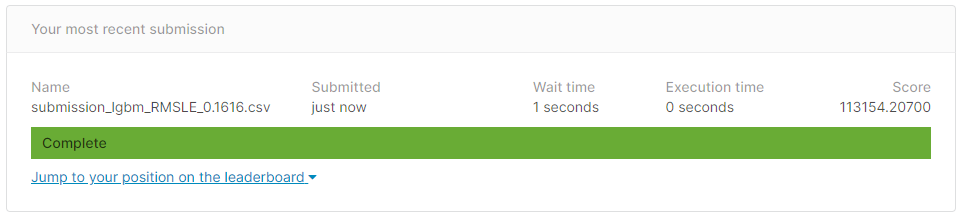